In [1]:
import cupy as cp
from cupy.linalg import svd

class HODLR_ND_GPU:
    def __init__(self, points, kernel_fn, tol=1e-6, min_size=32):
        """
        points : (n,d) np.ndarray or cp.ndarray
        kernel_fn : callable(p1,p2)->float (runs CPU)
        """
        # Store points on CPU (GPUs bad at branching kernels)
        self.points = points if isinstance(points, np.ndarray) else cp.asnumpy(points)
        self.n = self.points.shape[0]
        self.kernel_fn = kernel_fn
        self.tol = tol
        self.min_size = min_size
        self.is_leaf = self.n <= min_size

        if self.is_leaf:
            # Construct full block on CPU → transfer to GPU once
            A = np.array([[kernel_fn(self.points[i], self.points[j])
                           for j in range(self.n)]
                          for i in range(self.n)])
            self.A = cp.asarray(A)
            self.A11 = self.A22 = None
            self.U12 = self.V12 = None
            self.U21 = self.V21 = None
            return

        # Recursive Partition
        spreads = self.points.max(axis=0) - self.points.min(axis=0)
        axis = np.argmax(spreads)
        sorted_idx = np.argsort(self.points[:, axis])
        mid = self.n // 2

        self.idx1 = sorted_idx[:mid]
        self.idx2 = sorted_idx[mid:]

        P1 = self.points[self.idx1]
        P2 = self.points[self.idx2]

        # Build A12, A21 on CPU then move to GPU
        A12 = np.array([[kernel_fn(p1,p2) for p2 in P2] for p1 in P1])
        A21 = np.array([[kernel_fn(p2,p1) for p1 in P1] for p2 in P2])

        self.U12, self.V12 = self.low_rank(cp.asarray(A12))
        self.U21, self.V21 = self.low_rank(cp.asarray(A21))

        # Recurse on diagonal blocks
        self.A11 = HODLR_ND_GPU(P1, kernel_fn, tol, min_size)
        self.A22 = HODLR_ND_GPU(P2, kernel_fn, tol, min_size)

    def low_rank(self, block):
        if block.size == 0:
            return None, None
        U, s, Vt = svd(block, full_matrices=False)
        r = cp.sum(s > self.tol)
        if r == 0:
            return None, None
        U_r = U[:, :r]
        V_r = Vt[:r, :]
        S_r = cp.diag(s[:r])
        return U_r @ S_r, V_r

    def matvec(self, x):
        x = cp.asarray(x)  # ensure GPU vector

        if self.is_leaf:
            return self.A @ x

        x1 = x[self.idx1]
        x2 = x[self.idx2]

        y1 = self.A11.matvec(x1)
        y2 = self.A22.matvec(x2)

        if self.U12 is not None:
            y1 += self.U12 @ (self.V12 @ x2)
        if self.U21 is not None:
            y2 += self.U21 @ (self.V21 @ x1)

        y = cp.empty_like(x)
        y[self.idx1] = y1
        y[self.idx2] = y2
        return y


In [2]:
import numpy as np

n, d = 5000, 6
points = np.random.rand(n, d)

def kernel_fn(p1, p2):
    return 1.0 / (1.0 + np.linalg.norm(p1 - p2))

hodlr = HODLR_ND_GPU(points, kernel_fn, tol=1e-2, min_size=64)

v = np.random.randn(n)
y_gpu = hodlr.matvec(v)

print("GPU HODLR matvec complete:", y_gpu.shape)


GPU HODLR matvec complete: (5000,)


In [2]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

sizes = [200, 500, 1000, 2000, 4000,10000]  # adjust as needed
build_times = []
mv_times = []
errors = []

for N in sizes:
    print(f"\n--- Testing N = {N} ---")
    d = 5
    points = np.random.rand(N, d).astype(np.float32)

    def kernel_fn(p1, p2):
        return float(np.dot(p1, p2))

    v = np.random.randn(N).astype(np.float32)

    # exact matvec
    P = cp.asarray(points)
    v_gpu = cp.asarray(v)

    t0 = time.time()
    exact = P @ (P.T @ v_gpu)
    exact = cp.asnumpy(exact)
    exact_time = time.time() - t0

    # GPU HODLR construction
    t1 = time.time()
    hodlr = HODLR_ND_GPU(points, kernel_fn, tol=1e-2, min_size=64)
    build_times.append(time.time() - t1)

    # GPU HODLR matvec
    t2 = time.time()
    result = hodlr.matvec(v_gpu)
    cp.cuda.Stream.null.synchronize()  # ensure timing captured
    mv_times.append(time.time() - t2)

    result_cpu = cp.asnumpy(result)
    err = np.linalg.norm(result_cpu - exact) / np.linalg.norm(exact)
    errors.append(err)

    print(f"Build = {build_times[-1]:.3f}s, MatVec = {mv_times[-1]:.3f}s, Error = {err:.2e}")



--- Testing N = 200 ---
Build = 5.350s, MatVec = 0.917s, Error = 9.92e-08

--- Testing N = 500 ---
Build = 3.579s, MatVec = 0.006s, Error = 1.82e-07

--- Testing N = 1000 ---
Build = 4.459s, MatVec = 0.013s, Error = 2.14e-07

--- Testing N = 2000 ---
Build = 10.192s, MatVec = 0.029s, Error = 1.15e-07

--- Testing N = 4000 ---
Build = 31.492s, MatVec = 0.055s, Error = 9.59e-08

--- Testing N = 10000 ---
Build = 221.769s, MatVec = 0.212s, Error = 6.17e-07


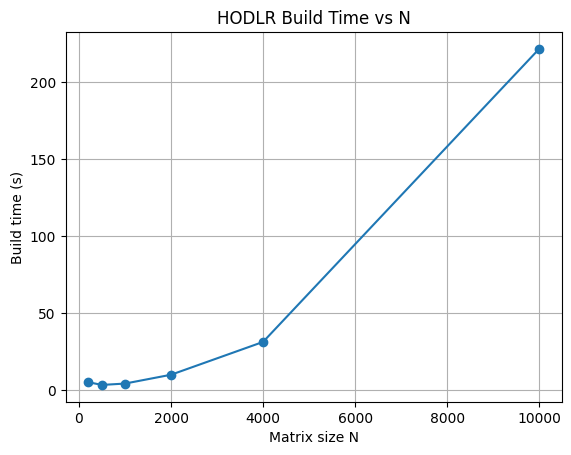

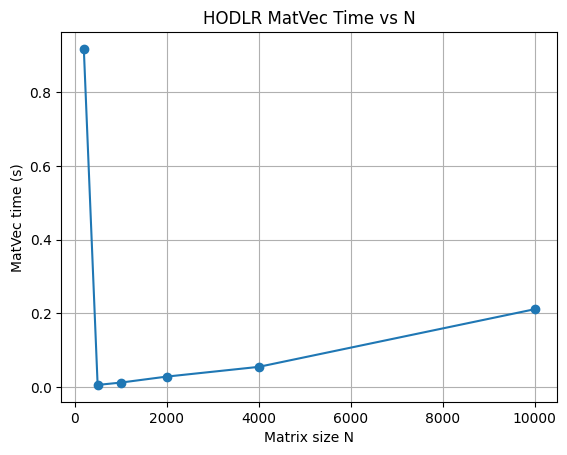

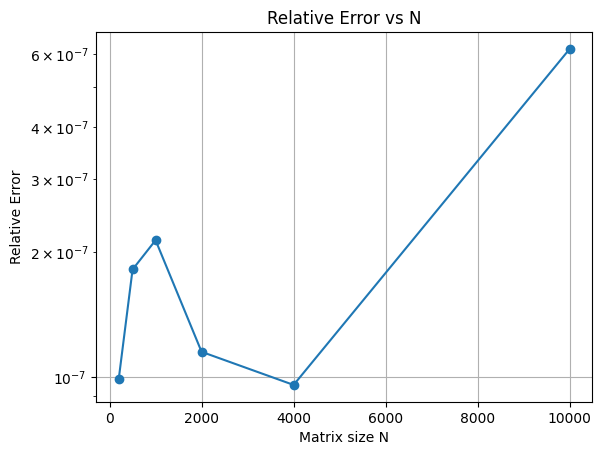

In [3]:
plt.figure()
plt.title("HODLR Build Time vs N")
plt.plot(sizes, build_times, marker='o')
plt.xlabel("Matrix size N")
plt.ylabel("Build time (s)")
plt.grid(True)
plt.show()

plt.figure()
plt.title("HODLR MatVec Time vs N")
plt.plot(sizes, mv_times, marker='o')
plt.xlabel("Matrix size N")
plt.ylabel("MatVec time (s)")
plt.grid(True)
plt.show()

plt.figure()
plt.title("Relative Error vs N")
plt.plot(sizes, errors, marker='o')
plt.xlabel("Matrix size N")
plt.ylabel("Relative Error")
plt.yscale("log")
plt.grid(True)
plt.show()



===== Testing dimension d = 2 =====
--- N = 200
Build: 9.563 sec
--- N = 500
Build: 3.300 sec
--- N = 1000
Build: 5.011 sec
--- N = 5000
Build: 50.429 sec
--- N = 10000
Build: 216.714 sec

===== Testing dimension d = 5 =====
--- N = 200
Build: 0.084 sec
--- N = 500
Build: 0.436 sec
--- N = 1000
Build: 1.548 sec
--- N = 5000
Build: 45.110 sec
--- N = 10000
Build: 218.726 sec

===== Testing dimension d = 10 =====
--- N = 200
Build: 0.083 sec
--- N = 500
Build: 0.421 sec
--- N = 1000
Build: 1.571 sec
--- N = 5000
Build: 45.149 sec
--- N = 10000
Build: 221.763 sec

===== Testing dimension d = 20 =====
--- N = 200
Build: 0.111 sec
--- N = 500
Build: 0.425 sec
--- N = 1000
Build: 1.576 sec
--- N = 5000
Build: 46.664 sec
--- N = 10000
Build: 222.286 sec


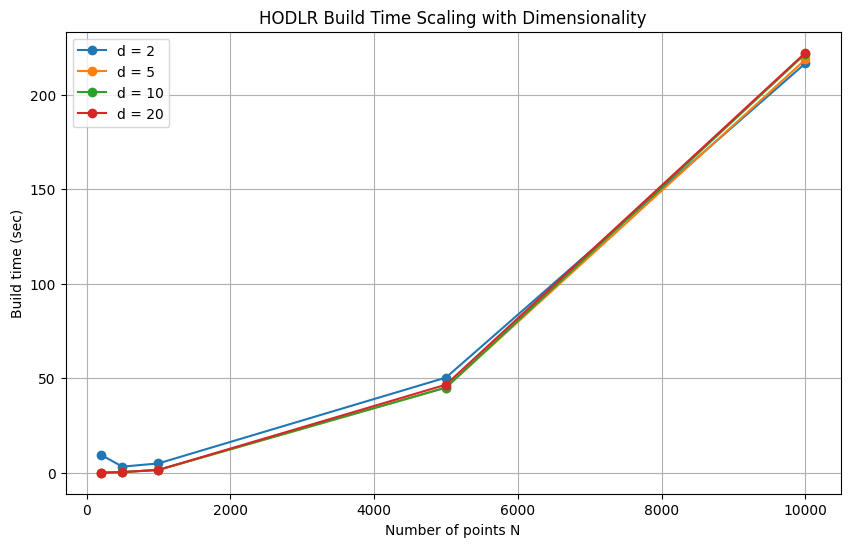

In [2]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

dims = [2, 5, 10, 20]  # dimensionalities to compare
sizes = [200, 500, 1000, 5000, 10000]  # number of points

build_times_all = {}

for d in dims:
    build_times = []
    print(f"\n===== Testing dimension d = {d} =====")

    for N in sizes:
        print(f"--- N = {N}")

        # Random points in d-D
        points = np.random.rand(N, d).astype(np.float32)

        # Inner product kernel (exact structure)
        def kernel_fn(p1, p2):
            return float(np.dot(p1, p2))

        # Build timing
        t0 = time.time()
        hodlr = HODLR_ND_GPU(points, kernel_fn, tol=1e-2, min_size=64)
        cp.cuda.Stream.null.synchronize()
        elapsed = time.time() - t0

        build_times.append(elapsed)
        print(f"Build: {elapsed:.3f} sec")

    build_times_all[d] = build_times


# ---------- Plot ----------
plt.figure(figsize=(10, 6))
for d in dims:
    plt.plot(sizes, build_times_all[d], marker='o', label=f"d = {d}")

plt.title("HODLR Build Time Scaling with Dimensionality")
plt.xlabel("Number of points N")
plt.ylabel("Build time (sec)")
plt.grid(True)
plt.legend()
plt.show()
